In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils.metric import *
# import properscoring as ps
from tqdm import tqdm
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
torch.load("./data/load_train.pt").shape

/tmp/ipykernel_75544/2663500575.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("./data/load_train.pt").shape


torch.Size([8760, 96])

In [3]:
M = 20
X = torch.load("./data/load_test.pt").unsqueeze(1).repeat(1, M, 1)
X_hat_gan = torch.load("./result/data/load_hat_gan.pt")[:, :M, :]
X_hat_diff_base = torch.load("./result/data/load_hat_diff_base.pt")[:, :M, :]
X_hat_diff_phy = torch.load("./result/data/load_hat_diff_phy.pt")[:, :M, :]
X_hat_vae = torch.load("./result/data/load_hat_vae.pt")[:, :M, :]
X_hat_nf = torch.load("./result/data/load_hat_nf.pt")[:, :M, :]

/tmp/ipykernel_75544/2687782414.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load("./data/load_test.pt").unsqueeze(1).repeat(1, M, 1)
/tmp/ipykernel_75544/2

In [4]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ps_gan = calculate_pinball_loss(X[:, 0, :], calculate_quantile_forecasts(X_hat_gan, quantiles), quantiles)
ps_vae = calculate_pinball_loss(X[:, 0, :], calculate_quantile_forecasts(X_hat_vae, quantiles), quantiles)
ps_nf = calculate_pinball_loss(X[:, 0, :], calculate_quantile_forecasts(X_hat_nf, quantiles), quantiles)
ps_diff_base = calculate_pinball_loss(X[:, 0, :], calculate_quantile_forecasts(X_hat_diff_base, quantiles), quantiles)
ps_diff_phy = calculate_pinball_loss(X[:, 0, :], calculate_quantile_forecasts(X_hat_diff_phy, quantiles), quantiles)

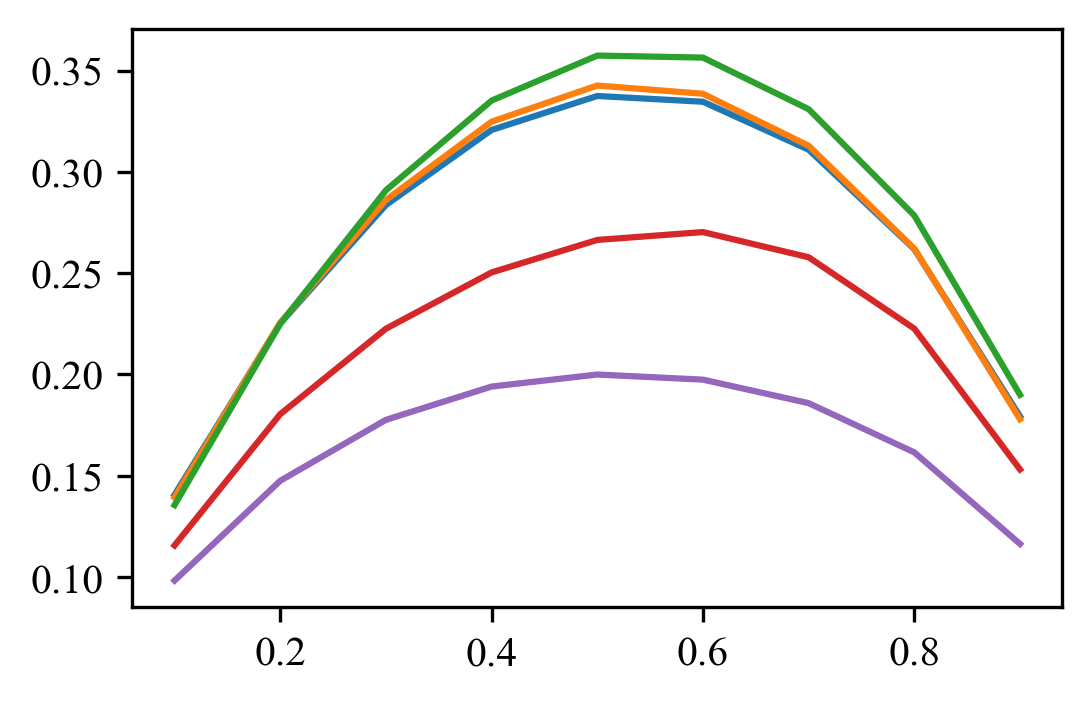

In [5]:
plt.figure(figsize=(4, 2.5), dpi=300)
plt.plot(quantiles, ps_gan, label = "GAN")
plt.plot(quantiles, ps_vae, label = "VAE")
plt.plot(quantiles, ps_nf, label = "NF")
plt.plot(quantiles, ps_diff_base, label = "BDM")
plt.plot(quantiles, ps_diff_phy, label = "PDM")
# plt.ylim(0.1, 0.8)
# plt.legend(fontsize=8, loc = "upper left")
plt.savefig("./result/plots/PS.jpg")

In [6]:
X.shape, X_hat_gan.shape, X_hat_diff_base.shape, X_hat_diff_phy.shape

(torch.Size([2190, 20, 96]),
 torch.Size([2190, 20, 96]),
 torch.Size([2190, 20, 96]),
 torch.Size([2190, 20, 96]))

In [7]:
def es(x, x_hat):
    es = 0
    term_1 = 0
    term_2 = 0
    M = x.shape[0]
    for i in range(M):
        term_1 = term_1 + torch.norm(x_hat[i] - x[i])
        for j in range(M):
            term_2 = term_2 + torch.norm(x_hat[i]- x_hat[j])
    es = es + term_1 /M  - term_2 / (2 * M**2)
    return es

In [8]:
def crps(x, x_hat):
    crps = 0
    term_1 = 0
    term_2 = 0
    M = len(x)
    for i in range(M):
        term_1 = term_1 + torch.abs(x_hat[i] - x[i])
        for j in range(M):
            term_2 = term_2 + torch.abs(x_hat[i]- x_hat[j])
    crps = crps + term_1 /M  - term_2 / (2 * M**2)
    return crps

In [9]:
def vs(x, x_hat):
    x = x.T
    x_hat = x_hat.T # [96, 20]
    T = x.shape[0]
    vs = 0
    for i in range(T):
            for j in range(i+1, T):
                term_1 = torch.sqrt(torch.abs(x[i][0] - x[j][0]))
                term_2 = torch.mean(torch.sqrt(torch.abs(x_hat[i] - x_hat[j])))
                vs = vs + (term_1 - term_2) ** 2
    return vs
    

In [10]:
def crps_margin(X, X_hat):
    # CRPS
    TS = X.shape[0] # num of test data
    T = X.shape[2]
    CRPS = []
    for i in tqdm(range(T)):
        temp = 0
        for j in range(TS):
            x = X[j, :, i]
            x_hat = X_hat[j, :, i]
            temp = temp + crps(x, x_hat)
        CRPS.append(temp/TS)
    return CRPS

In [11]:
CRPS_gan = crps_margin(X, X_hat_gan)
CRPS_vae = crps_margin(X, X_hat_vae)
CRPS_nf = crps_margin(X, X_hat_nf)
CRPS_diff_base = crps_margin(X, X_hat_diff_base)
CRPS_diff_phy = crps_margin(X, X_hat_diff_phy)


 40%|███▉      | 38/96 [03:25<05:13,  5.41s/it]


KeyboardInterrupt: 

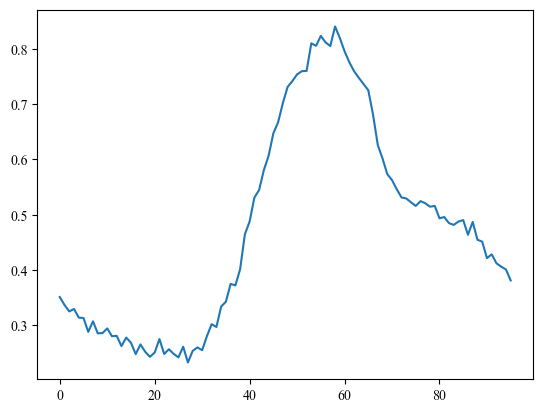

In [ ]:
plt.plot(CRPS_gan)

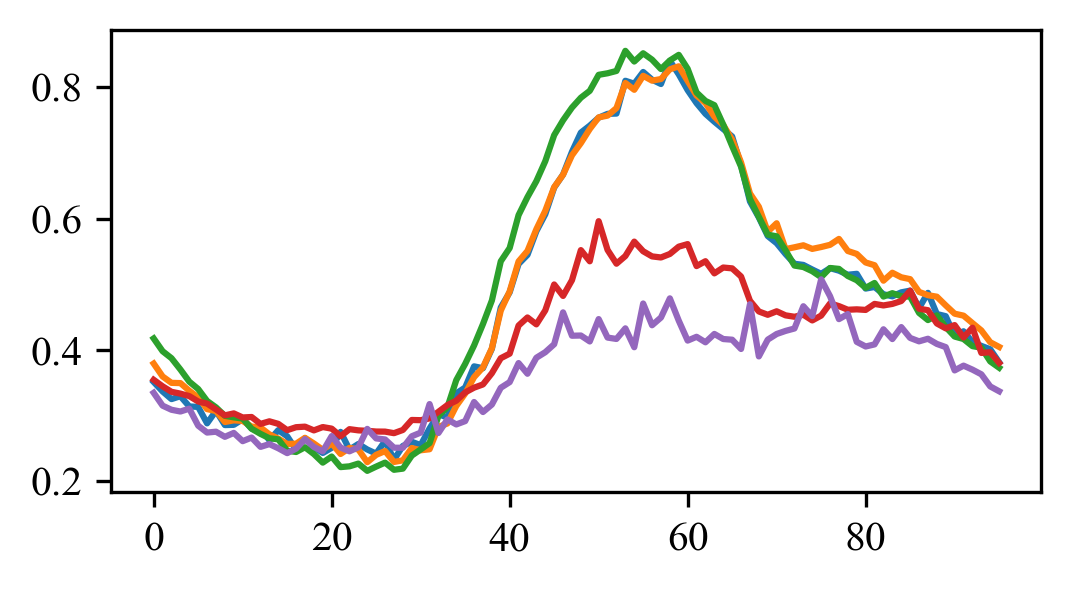

In [ ]:
plt.figure(figsize=(4, 2), dpi=300)
plt.plot(CRPS_gan, label = "GAN")
plt.plot(CRPS_vae, label = "VAE")
plt.plot(CRPS_nf, label = "NF")
plt.plot(CRPS_diff_base, label = "BDM")
plt.plot(CRPS_diff_phy, label = "PDM")
# plt.legend(fontsize=8)
plt.savefig("./result/plots/CRPS.jpg")

Load Forecasting Metric: MAE and RMSE

In [ ]:
def evaluation(X, X_hat):
    TS = X.shape[0] # num of test data
    M = X.shape[1] # num of senarios
    T = X.shape[2]
    # MAE; RMSE
    MAE = 0
    RMSE = 0
    
    for i in tqdm(range(TS)):
        for j in range(M):
            x = X[i, j, :]
            x_hat = X_hat[i, j, :]
            MAE = MAE + mean_absolute_error(x,x_hat)
            RMSE = RMSE + mean_squared_error(x, x_hat)
    MAE = MAE / (TS * M)
    RMSE = RMSE / (TS * M)
    print(f'MAE: {MAE:.4f}')
    print(f'RMSE: {RMSE:.4f}')
    # PS
    PS = np.mean(pinball_Loss(X, X_hat))
    print(f'PS: {PS:.4f}')
    # CRPS
    CRPS = 0
    for i in tqdm(range(T)):
        for j in range(TS):
            x = X[j, :, i]
            x_hat = X_hat[j, :, i]
            CRPS = CRPS + crps(x, x_hat)
    CRPS = CRPS / (T * TS)
    print(f'CRPS: {CRPS:.4f}')
    # ES
    ES = 0
    for i in tqdm(range(TS)):
        x = X[i]
        x_hat = X_hat[i]
        ES = ES + es(x, x_hat)
    ES = ES / TS
    print(f'ES: {ES:.4f}')
    # VS
    VS = 0
    for i in tqdm(range(TS)):
        VS = VS + vs(X[i], X_hat[i])
    VS = VS / TS
    print(f'VS: {VS:.4f}')


In [ ]:
evaluation(X, X_hat_nf)

  2%|▏         | 51/2190 [00:00<00:17, 121.20it/s]

100%|██████████| 2190/2190 [00:17<00:00, 126.76it/s]


MAE: 0.9213
RMSE: 1.7022
PS: 0.2672


100%|██████████| 96/96 [08:16<00:00,  5.17s/it]


CRPS: 0.4885


100%|██████████| 2190/2190 [00:07<00:00, 297.34it/s]


ES: 6.5494


100%|██████████| 2190/2190 [04:01<00:00,  9.06it/s]

VS: 1125.9501


In [ ]:
evaluation(X, X_hat_vae)

100%|██████████| 2190/2190 [00:17<00:00, 126.78it/s]


MAE: 0.8319
RMSE: 1.3333
PS: 0.2630


100%|██████████| 96/96 [08:14<00:00,  5.15s/it]


CRPS: 0.4819


100%|██████████| 2190/2190 [00:07<00:00, 302.12it/s]


ES: 6.2551


100%|██████████| 2190/2190 [03:59<00:00,  9.15it/s]

VS: 968.5557


In [ ]:
evaluation(X, X_hat_gan)

100%|██████████| 2190/2190 [00:17<00:00, 125.51it/s]


MAE: 0.8589
RMSE: 1.4301
PS: 0.2601


100%|██████████| 96/96 [08:14<00:00,  5.15s/it]


CRPS: 0.4744


100%|██████████| 2190/2190 [00:07<00:00, 297.84it/s]


ES: 6.1367


100%|██████████| 2190/2190 [03:59<00:00,  9.13it/s]

VS: 965.9626


In [ ]:
evaluation(X, X_hat_diff_phy)

100%|██████████| 2190/2190 [00:17<00:00, 122.68it/s]


MAE: 0.6285
RMSE: 0.7074
PS: 0.1932


100%|██████████| 96/96 [08:16<00:00,  5.17s/it]


CRPS: 0.3596


100%|██████████| 2190/2190 [00:07<00:00, 299.75it/s]


ES: 4.4837


100%|██████████| 2190/2190 [04:00<00:00,  9.12it/s]

VS: 675.8768


In [ ]:
evaluation(X, X_hat_diff_base)

100%|██████████| 2190/2190 [00:17<00:00, 126.85it/s]


MAE: 0.8777
RMSE: 1.2796
PS: 0.2267


100%|██████████| 96/96 [08:14<00:00,  5.15s/it]


CRPS: 0.4088


100%|██████████| 2190/2190 [00:07<00:00, 300.06it/s]


ES: 5.0699


100%|██████████| 2190/2190 [04:00<00:00,  9.10it/s]

VS: 922.5298
